### Imports

In [1]:
import sys
sys.path.append('/hpc/vvib872/Code/tune')

In [3]:
%load_ext autoreload

from dask.distributed import Client
from tune.paralell.dask_image_processing import Image
from tune.paralell import recipes
import SimpleITK as sitk
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['image.cmap'] = 'gray'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Create a cluster on a separate notebook and create a client here

In [4]:
client = Client('tcp://127.0.0.1:44139')

### Load Image

In [5]:
file_path = '/eresearch/heart/vvib872/MAIN/SORT/MuSIC/CV58-E/BlockR/210308-132509/rechunked_BlockR_640_020.zarr'
img = Image.from_zarr(file_path)
img.info()

image_path: /eresearch/heart/vvib872/MAIN/SORT/MuSIC/CV58-E/BlockR/210308-132509/rechunked_BlockR_640_020.zarr


,Array,Chunk
Bytes,63.42 GB,73.40 MB
Shape,"(560, 2048, 13824)","(280, 256, 256)"
Count,865 Tasks,864 Chunks
Type,float32,numpy.ndarray


### Common parameters

In [6]:
plane = 'XZ'
slice_no = 5000
img_start=(0,0)
img_end=(None,None)
clim=(0,200)

chunk_size = (280,256,256)

### Test on a sample block

In [7]:
sample_range = ((100,380),(1000,2024),(5000,6024))
sample_path = img.sample(sample_range, prefix='sample',chunk_size=chunk_size)

/eresearch/heart/vvib872/MAIN/SORT/MuSIC/CV58-E/BlockR/210308-132509/sample/sample_rechunked_BlockR_640_020.zarr


In [20]:
img = Image.from_zarr(sample_path)
img.info()

image_path: /eresearch/heart/vvib872/MAIN/SORT/MuSIC/CV58-E/BlockR/210308-132509/sample/sample_rechunked_BlockR_640_020.zarr


dask.array<from-zarr, shape=(280, 1024, 1024), dtype=float32, chunksize=(280, 256, 256), chunktype=numpy.ndarray>

### View Image

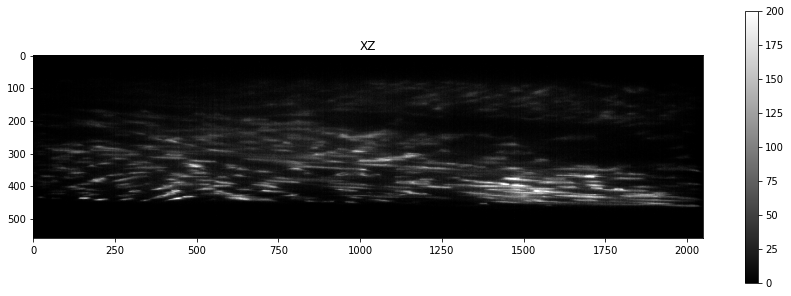

In [7]:
img.visualize(plane = plane, slice_no=slice_no, img_start=img_start,img_end=img_end,clim=clim)

### Deconvolution

Shape:  (121, 81, 81)
Max:  1.0
Min:  0.0
Mean:  0.015491667
OTF calculated
(0, 0, 0)
Creating plans for FFTs - this might take a while
Elapsed time: 10277.103595495224
/eresearch/heart/vvib872/MAIN/SORT/MuSIC/CV58-E/BlockR/210308-132509/deconv_rechunked_BlockR_640_020.zarr


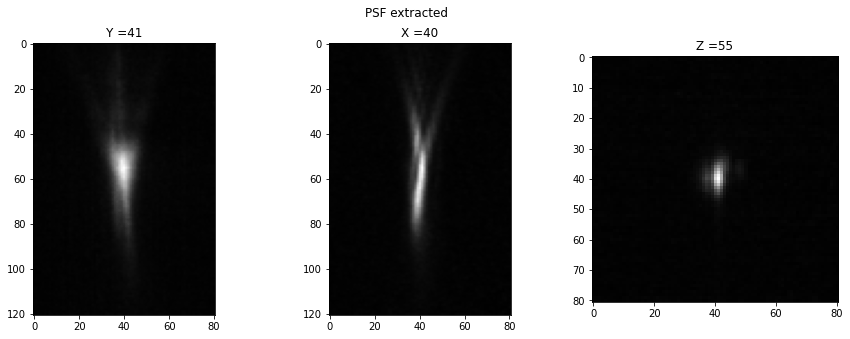

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [8]:
deconv_img_path = recipes.deconvolve(img,
                                     img_resolution = (8*0.23325,0.23325,4*0.23325), 
                                     chunk_size = chunk_size, 
                                     prefix = 'deconv', 
                                     overlap = (64,64,64), 
                                     psf_invert= False,
                                     psf_path = '/hpc_utoz/vvib872/Data/PSF/CV_us_640_fine.tif',
#                                      psf_path = '/hpc_utoz/vvib872/Data/PSF/PSF_16bit_full.tif',
                                     psf_res = (0.23325,0.23325,0.23325), 
                                     iterations = 40, 
                                     save_chunk_size = chunk_size,
                                     client= client)

### Deconvolved

In [ ]:
img = Image.from_zarr(deconv_img_path)
img.visualize(plane = plane, slice_no=slice_no, img_start=img_start,img_end=img_end,clim=clim)

### BG correction

Image range: (0, 44886)
Clipped image range: (9.0, 1051.0)
Otsu threshold: 793.0
Elapsed time: 7.260028123855591
/hpc/vvib872/Data/carotid/SHR2_R/bg_dSHR_carotid_02_01_R.tif.zarr


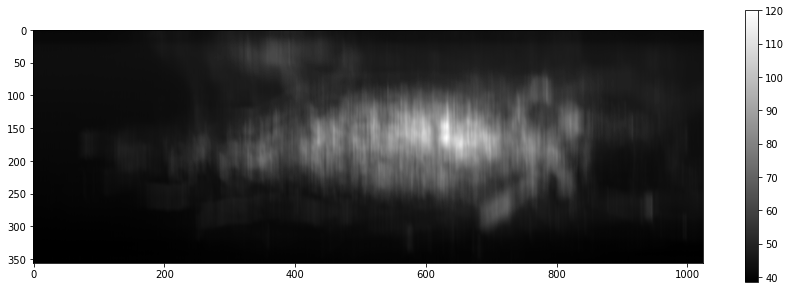

In [28]:
bg_img_path = recipes.bg_correction(img,
                                    bg_percentile = 0.001,
                                    vertical_window = 40,
                                    mean_chunk_size = chunk_size[0:2] +(1,),
                                    bg_chunks = chunk_size,
                                    client = client,
                                    prefix='bg')

### BG_Corrected

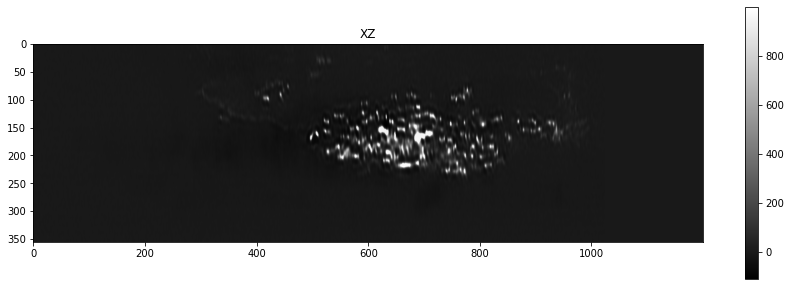

In [29]:
img = Image.from_zarr(bg_img_path)
img.visualize(plane = plane, slice_no=slice_no, img_start=img_start,img_end=img_end)

### Normalization

In [30]:
norm_img_path = recipes.normalize(img,
                                  rescale_gamma = 1, #1.5
                                  rescale_lp = 0.2, #.25
                                  rescale_up = 1e-5,#0.001
                                  save_chunk_size = chunk_size,
                                  client=client,
                                  prefix='norm')

Image range: (-111.08003, 1010.17346)
Clipped image range: (-6.663300695419309, 1006.5293880577087)
Otsu threshold: 294.1479883122444
Elapsed time: 7.383532524108887
/hpc/vvib872/Data/carotid/SHR2_R/norm_bg_dSHR_carotid_02_01_R.tif.zarr
Otsu threshold after normalization: 0.2968944528980495


### Normalized

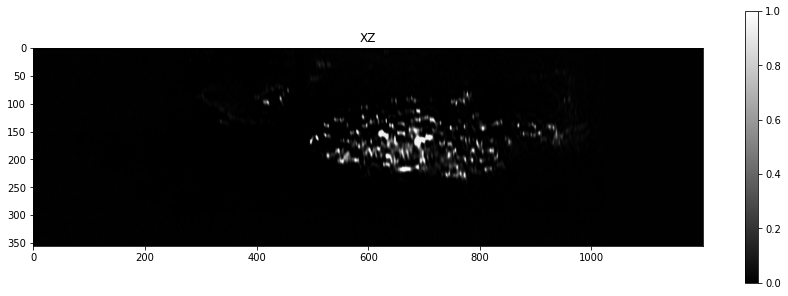

In [31]:
img = Image.from_zarr(norm_img_path)
img.visualize(plane = plane, slice_no=slice_no, img_start=img_start,img_end=img_end,clim=(0,1))

### Diffusion

In [32]:
diff_img_path = recipes.diffuse(img,
                                overlap=(16,16,16),
                                diffuse_niter = 10,
                                diffuse_kappa = 5,
                                diffuse_gamma = 0.1,
                                diffuse_voxels = (1,1,1),
                                save_chunk_size = chunk_size, 
                                client=client,
                                prefix='diff')

/hpc_utoz/vvib872/Software/envs/deconv/lib/python3.8/site-packages/medpy/filter/smoothing.py:155: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  deltas[i][slicer] = numpy.diff(out, axis=i)
/hpc_utoz/vvib872/Software/envs/deconv/lib/python3.8/site-packages/medpy/filter/smoothing.py:164: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  matrices[i][slicer] = numpy.diff(matrices[i], axis=i)


Elapsed time: 58.72758436203003
/hpc/vvib872/Data/carotid/SHR2_R/diff_norm_bg_dSHR_carotid_02_01_R.tif.zarr


### Diffused

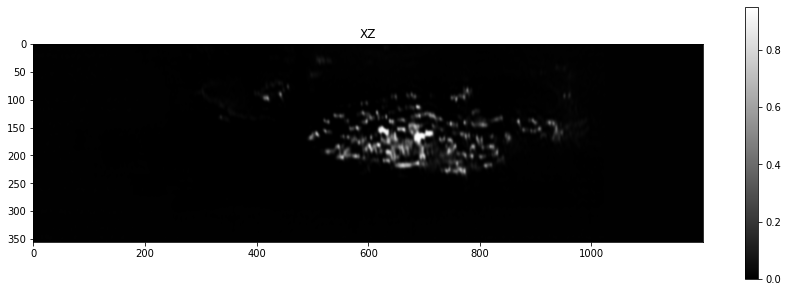

In [33]:
img = Image.from_zarr(diff_img_path)
img.visualize(plane = plane, slice_no=slice_no, img_start=img_start,img_end=img_end)

### Normalization

In [34]:
norm_img_path = recipes.normalize(img,
                                  rescale_gamma = 1, #1.5
                                  rescale_lp = 0.1, #.25
                                  rescale_up = 1e-5,#0.001
                                  save_chunk_size = chunk_size,
                                  client=client,
                                  prefix='norm')

Image range: (0.0, 0.99309105)
Clipped image range: (0.0, 0.9758981580622494)
Otsu threshold: 0.17205302385985852
Elapsed time: 8.082624673843384
/hpc/vvib872/Data/carotid/SHR2_R/norm_diff_norm_bg_dSHR_carotid_02_01_R.tif.zarr
Otsu threshold after normalization: 0.17630223239839726


### Normalized

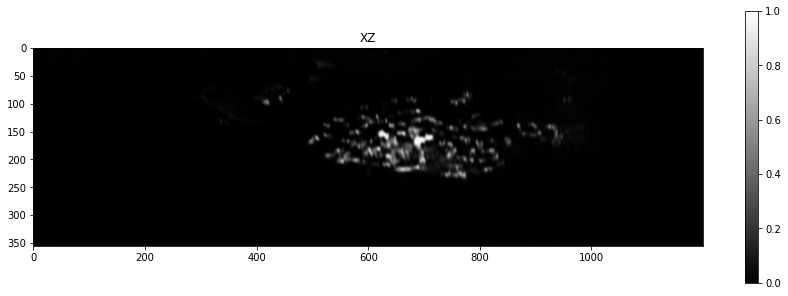

In [40]:
img = Image.from_zarr(norm_img_path)
img.visualize(plane = plane, slice_no=slice_no, img_start=img_start,img_end=img_end,clim=(0,1))

### Segmentation

In [41]:
seg_img_path = recipes.segment(img,
                               overlap=(32,32,32), 
                               init_val = 0.25,
                               active_contour= 0,
                               gauss_sigma = 0,
                               cl_threshold = 500,
                               save_chunk_size = chunk_size,
                               client=client,
                               prefix='seg')

Elapsed time: 5.030369520187378
/hpc/vvib872/Data/carotid/SHR2_R/seg_norm_diff_norm_bg_dSHR_carotid_02_01_R.tif.zarr


### Segmented

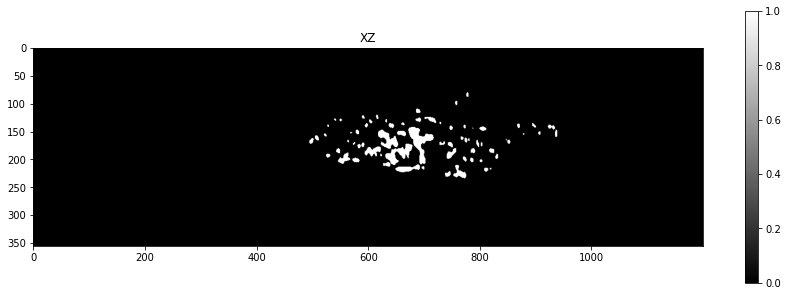

In [42]:
seg_img = Image.from_zarr(seg_img_path)
seg_img.visualize(plane = plane, slice_no=slice_no, img_start=img_start,img_end=img_end,clim=(0,1))

In [157]:
recipes.save_tif_slices(seg_img_path)

Elapsed time: 1.0976970195770264


1

In [ ]:
client.close()